In [1]:
import numpy as np
import pandas as pd
from os import listdir

import  matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from scipy import ndimage
from skimage.feature import peak_local_max, corner_peaks
from tqdm import tqdm

# Функции считывания FL-карт

<a id='import_df'></a>

In [2]:
def import_df(filename, source_path = '..\CD_HM_dataset\\'):
    '''
    Imports data from xlsx to df.
    
    filename: name of the file.
    source_path: path to the file.
    '''

    df = pd.read_csv(source_path + filename) # Reading xlsx -> df 
    #df = df.drop(['Unnamed: 552']) # Delete last raw
    
    df = df.astype(float)
    #df.columns = df.columns.astype('int')
    
    # Filtering
    df[df<0] = np.nan #np.nan
    
    df.index = df[df.columns[0]]
    df.index = df.index.astype('int')
    df = df.drop('EX Wavelength/EM Wavelength', axis=1) # Delete last raw
    df.columns = df.columns.astype('int')
    
    return df

<a id='show_im'></a>

In [3]:
def show_im(df, filename, 
            figsize=(10, 6), 
            vmax = None,
            vmin = None,
            cmap = None,
            phys_view = False):
    '''
    For drawing heat map of FL.
    
    df: FL df.
    filename:  name of the file.
    vmax: Max value (color) on heatmap.
    vmin: Min value (color) on heatmap.
    cmap: cmap for heatmap drawing.
    phys_view: Transpose for as-experimental view heatmap.
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if phys_view == True:
        ax = sns.heatmap(df[::-1] , vmax = vmax, vmin = vmin, cmap = cmap)
    else:
        ax = sns.heatmap(df, vmax = vmax, vmin = vmin, cmap = cmap)
        
    ax.set(xlabel="EM Wavelength", ylabel="EX Wavelength")
    ax.set_title(filename)

<a id='p_show_img'></a>

In [4]:
def p_show_img(df, filename, 
              square_fig = False,
              vmax = None,
              vmin = None,
              cmap = None,
              points = None,
              l_xy_width = None
              #points_disp_1 = None,
              #points_disp_2 = None
              ):
    '''
    For drawing heat map of FL with interactive Plotly lib.

    df: FL df.
    filename:  name of the file.
    square_fig: show square-form heatmap.
    vmax: max value (color) on heatmap.
    vmin: min value (color) on heatmap.
    points: 
    '''            
    # create the heatmap
    if (vmax!=None or vmin!=None):
        x = df.axes[0].to_list()
        y = df.axes[1].to_list()
        heatmap = go.Heatmap(z = np.array(df), x = df.columns, y = df.index, zauto = False, 
                             zmax = vmax, zmin = vmin) # , colorscale='Blues'
    else:
        heatmap = go.Heatmap(z = np.array(df), x = df.columns, y = df.index)
    
    # create the layout
    layout = go.Layout(title=filename,
                       xaxis=dict(title="EM Wavelength"),
                       yaxis=dict(title="EX Wavelength"))
    # create the figure
    fig = go.Figure(heatmap, layout=layout)
    
    if square_fig:
        fig.update_layout(autosize=False, width=550, height=550)
        
    if hasattr(points, '__iter__'):
        wave_length_coord = np.array([[df.index[i[0]], df.columns[i[1]]] for i in points])
        fig.add_trace(go.Scatter(x=wave_length_coord[:,1], y=wave_length_coord[:,0], mode='markers', marker={'color': 'forestgreen'}))
    
    l_colors = ['snow', 'silver', 'matter', 'tropic']
    if hasattr(l_xy_width, '__iter__'):
        for points_disp, color in zip(l_xy_width, l_colors):
            fig.add_trace(go.Scatter(x=points_disp[:,1], y=points_disp[:,0], mode='markers', marker={'color': color}))
    
    '''
    if hasattr(points_disp_1, '__iter__'):
        fig.add_trace(go.Scatter(x=points_disp_1[:,1], y=points_disp_1[:,0], mode='markers', marker={'color': 'snow'}))
        
    if hasattr(points_disp_2, '__iter__'):
        fig.add_trace(go.Scatter(x=points_disp_2[:,1], y=points_disp_2[:,0], mode='markers', marker={'color': 'silver'}))
    '''    
    # show the figure
    fig.show()

### Обработка

<a id='lines_deleting'></a>

In [5]:
def lines_deleting(df):
    '''
    Deletes signal of elastic scattering (y=x) and diffraction grating (y=2x)
    
    df: FL df.
    '''
    df_bool_matrix = pd.DataFrame(np.ones([len(df.index), len(df.columns)]), index=df.index, columns=df.columns)
    
    for i in (df.index):
        for j in [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]:
            if (i in df.index) and (i+j) in df.columns:
                df_bool_matrix.loc[i, (i+j)] = np.nan
            if (i in df.index) and (i*2+j) in df.columns:
                df_bool_matrix.loc[i, (i*2+j)] = np.nan
            
    return df_bool_matrix*df

<a id='blow_outs_filt'></a>

In [6]:
def _mean_in_window(matr, ker_size = [3, 5]):
    '''
    Evaluates mean in window.
    
    df: FL df.
    ker_size: kernal (of ones) shape.
    '''
    # Convoluction block
    kernel = np.ones(ker_size) # kernal matrix
    kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
    
    matr_mean = ndimage.convolve(matr, kernel, mode = 'constant') # Convolution of df with kernel. Evaluating MEAN in window.
    
    return matr_mean

def blow_outs_filt(df, ker_size = [3, 5], n_sigma = 5):
    '''
    Evaluates dispersion of each each pixel in window ker_size. And filters pixel according to n-sigma rule.
    
    df: FL df.
    ker_size: kernal (of ones) shape.
    n_sigma: number of sigma to detect blow_outs.
    '''
    
    np_df = np.array(df) # df --> np_df
    np_df[np_df!=np_df] = 0 # For correct mean-window-evaluating
    
    # Evaluating 1-st summand
    np_df_2_MEAN = _mean_in_window(np_df**2, ker_size = ker_size)
    
    # Evaluating 2-st summand
    np_df_MEAN = _mean_in_window(np_df, ker_size = ker_size)
    np_df_MEAN_2 = (np_df_MEAN)**2
    
    # Evaluating dispertion
    np_df_disp = np.sqrt(np_df_2_MEAN - np_df_MEAN_2)
    
    # Filtering according to n-sigma rule
    np_df_filtered = np.array(df)
    np_df_filtered[(np_df - np_df_MEAN) > (n_sigma * np_df_disp)] = None 
    
    return pd.DataFrame(np_df_filtered, index=df.index, columns=df.columns)

<a id='iter_filter'></a>

In [7]:
def _filter(df, trash_h = 0, ker_size = [3, 5]):
    '''
    Filters df, relying on number of None in neighbours of pixel
    
    df: FL df.
    trash_h: bounder for number of None neighbours. Lies between [-1, 1].
    ker_size: kernal (of ones) shape.
    '''
    np_df = np.array(df) # df --> np_df
    
    # +-1 binerazing np_df
    np_df_bool = np_df.copy() 
    np_df_bool[np_df==np_df] = 1 # not None --> 1
    np_df_bool[np_df!=np_df] = -1 # None --> -1
    
    # Convoluction block
    kernel = np.ones(ker_size) # kernal matrix
    kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
    
    np_df_conv = ndimage.convolve(np_df_bool, kernel, mode = 'constant') # Convolution of np_df_bool with kernel
    
    # Binerising np_df_conv
    np_df_conv_bool = np_df_conv #.copy() 
    np_df_conv_bool[np_df_conv>=trash_h] = 1
    np_df_conv_bool[np_df_conv<trash_h] = np.nan
    
    # Filtering np_df
    np_filt = np_df * np_df_conv_bool
    
    return pd.DataFrame(np_filt, index=df.index, columns=df.columns)


def iter_filter(df, trash_h = 0, delta = 0.001, ker_size = [3, 5]):
    '''
    Iterative filtering of the noise using _filter().
    
    df: FL df.
    trash_h: bounder for number of None neighbours. Lies between [-1, 1].
    delta: minimum changing fraction of nones number in all df pixels 
    ker_size: kernal (of ones) shape.
    '''
    delta_pix = max(delta*np.prod(df.shape), 1) # stop criterium
    
    # Pre-iteration evaluation
    none_0 = df.isnull().sum().sum()
    df_1 = _filter(df, trash_h, ker_size = [5, 5])
    none_1 = df_1.isnull().sum().sum()
    
    # Iteratively applying _filter(); 
    # none_1, df_1 -{iter}-> none_0, _filter(df_1)
    #i =0
    ##print(none_0, none_1)
    while abs(none_1-none_0) > delta_pix:
        df_1 = _filter(df_1, trash_h=trash_h, ker_size = ker_size)
        none_0 = none_1
        none_1 = df_1.isnull().sum().sum()
        
        #i+=1
        #print(f'iteration {i}')
        #p_show_img(df_1, filename)
        ##print(none_0, none_1)
    
    #print(f'Total num of iterations: {i}')    
    return df_1

<a id='find_peaks'></a>

In [8]:
def find_peaks(df, min_distance = 5, num_peaks = 2):
    '''
    Searchs for extremums on df.
    
    df: FL df.
    min_distance: minimum distance between 2 extremums.
    num_peaks: number of extremums to search.
    '''
    return corner_peaks(np.array(df), min_distance=min_distance, num_peaks = num_peaks) #peak_local_max

<a id='width'></a>
<a id='maximum_width_est'></a>

In [9]:
def _nearest_nN_left(l_x, l_y, i):
    '''
    Finds left nearest not-None value in l_y and returns it`s index.
    
    l_x: list of corresponding arguments.
    l_y: list to search in.
    x_0: index of start point (with None-value y).
    '''
    while i>0:
        i+=-1
        if l_y[i]==l_y[i]:
            return i
        
        
def _nearest_nN_right(l_x, l_y, i):
    '''
    Finds right nearest not-None value in l_y and returns it`s index.
    
    l_x: list of corresponding arguments.
    l_y: list to search in.
    x_0: index of start point (with None-value y).
    '''
    while i<len(l_x)-1:
        i+=1
        if l_y[i]==l_y[i]:
            return i
        
        
def _approx_2_dots(l_dots):
    '''
    Returns function of 2-dot linear approximation.
    
    l_dots: [[x1,y1], [x2,y2]] list of dots to approximate.
    '''
    k = (l_dots[0][1]-l_dots[1][1]) / (l_dots[0][0]-l_dots[1][0])
    b = (l_dots[1][1]*l_dots[0][0]-l_dots[0][1]*l_dots[1][0]) / (l_dots[0][0]-l_dots[1][0])
    return lambda x: k*x + b
    
        
def width(l_x, l_y, i, k = 0.5, return_interp_cords = False):
    '''
    Evaluates width on max_amplitude*k level around maximum point.
    
    l_x: list of corresponding arguments.
    l_y: list to search in.
    i: index of start point.
    k: amplitude-level of width evaluating. 
    return_interp_cords: return interpolated 
    '''
    max_ampl = l_y[i]
    find_ampl = max_ampl*k
    
    # Going liberal :) {left}
    if l_y[0]!=l_y[0]: # Boundary condition for convergence
        l_y[0] = 0
        
    left_i = i
    while left_i > 0:
        left_i+=-1
        
        if l_y[left_i]!=l_y[left_i]: # If l_y[left_i]==None --> Evaluate l_y[left_i] with linear regrasion
            left_i2 = _nearest_nN_left(l_x, l_y, left_i)
            lin_regr = _approx_2_dots([[l_x[left_i+1], l_y[left_i+1]], [l_x[left_i2], l_y[left_i2]]]) # Finding linear reger.: x->y
            l_y[left_i] = lin_regr(l_x[left_i]) # Set current y according to linear reger.
        
        if l_y[left_i]<=find_ampl:
            break
        #print([l_x[left_i], l_y[left_i]])
        
        
    # Going communistic ;) {right}
    if l_y[-1]!=l_y[-1]: # Boundary condition for convergence
        l_y[-1] = 0
        
    right_i = i
    while right_i < len(l_y)-1:
        right_i+=1
        
        if l_y[right_i]!=l_y[right_i]: # If l_y[right_i]==None --> Evaluate l_y[right_i] with linear regression
            right_i2 = _nearest_nN_right(l_x, l_y, right_i)
            lin_regr = _approx_2_dots([[l_x[right_i-1], l_y[right_i-1]], [l_x[right_i2], l_y[right_i2]]])
            l_y[right_i] = lin_regr(l_x[right_i])
        
        if l_y[right_i]<=find_ampl:
            break
        

    if not return_interp_cords:
        out_vector = [l_x[left_i], l_x[right_i]]
    else:        
        x_bound_left = _approx_2_dots([[l_y[left_i+1], l_x[left_i+1]],[l_y[left_i], l_x[left_i]]])(find_ampl)
        x_bound_right = _approx_2_dots([[l_y[right_i-1],l_x[right_i-1]],[l_y[right_i],l_x[right_i]]])(find_ampl)
        
        out_vector = [[l_x[left_i], l_x[right_i]], [x_bound_left, x_bound_right]]
        
    return out_vector


def maximum_width_est(df, EX_EM_list, coordinates, k = 0.5, return_interp_cords=False):
    '''
    Estimates x and y-width coordinates [x_width, y_width]
    
    df: FL df.
    EX_EM_list: coordinates of maximas [[x_1, y_1], [x_2, y_2]]
    coordinates: indexes of maximas from EX_EM_list
    k: amplitude-level of width evaluating
    return_interp_cords: return interpolated l_width or not interpolated.
    
    returns: [[left_bound, right_bound, down_bound, up_bound], ...],
             [[left_bound_coords, right_bound_coords, down_bound_coords, up_bound_coords], ...]
    '''
    l_width, l_xy_width = [], []
    for i in range(len(EX_EM_list)):
        # x-width Evaluating
        l = df.loc[EX_EM_list[i][0]]
        x_width, x_width_exact = width(l_x = l.index, l_y = l.values, i = coordinates[i][1], k = k, return_interp_cords=True)
    
        # y-width Evaluating
        l = df.loc[:,EX_EM_list[i][1]]
        y_width, y_width_exact = width(l_x = l.index, l_y = l.values, i = coordinates[i][0], k = k, return_interp_cords=True)
        
        l_width.append([*x_width_exact, *y_width_exact])
        l_xy_width.append(np.array(
            ([[EX_EM_list[i][0], x_width[0]],
              [EX_EM_list[i][0], x_width[1]],
              [y_width[0], EX_EM_list[i][1]],
              [y_width[1], EX_EM_list[i][1]],
             ])))
    
    return l_width, l_xy_width

In [10]:
def maximum_integral_est(df, EX_EM_list, coordinates, k = 0.5):
    '''
    Estimates x and y-integrals between maximum and  coordinates [x_width, y_width]
    
    df: FL df.
    EX_EM_list: coordinates of maximas [[x_1, y_1], [x_2, y_2]]
    coordinates: indexes of maximas from EX_EM_list
    k: amplitude-level of width evaluating. 
    
    returns: [[I_x_left, I_x_right, I_y_down, I_y_up,], ...]
    '''
    l_I = []
    for i in range(len(EX_EM_list)):
        # x-width Evaluating
        l = df.loc[EX_EM_list[i][0]]
        x_width = width(l_x = l.index, l_y = l.values,  i = coordinates[i][1], k = k)
        left_wing = df.loc[EX_EM_list[i][0], x_width[0]:EX_EM_list[i][1]]
        right_wing = df.loc[EX_EM_list[i][0], EX_EM_list[i][1]:x_width[1]]
        I_x_left = np.sum(left_wing)
        I_x_right = np.sum(right_wing)
    
        # y-width Evaluating
        l = df.loc[:,EX_EM_list[i][1]]
        y_width = width(l_x = l.index, l_y = l.values,  i = coordinates[i][0], k = k)
        left_wing = df.loc[y_width[0]:EX_EM_list[i][0], EX_EM_list[i][1]]
        right_wing = df.loc[EX_EM_list[i][0]:y_width[1], EX_EM_list[i][1]]
        I_y_down = np.sum(left_wing)
        I_y_up = np.sum(right_wing)
        
        l_I.append(np.array(
            ([I_x_left,
              I_x_right,
              I_y_down,
              I_y_up,
             ])))
    
    return l_I

In [11]:
def plot_est(df, EX_EM_list, coordinates,k_x = 0.5, k_I = 0., ):
    '''
    Estimates x and y-integrals between maximum and  coordinates [x_width, y_width]
    
    df: FL df.
    EX_EM_list: coordinates of maximas [[x_1, y_1], [x_2, y_2]]
    coordinates: indexes of maximas from EX_EM_list
    k: amplitude-level of width evaluating. 
    
    returns: [[I_x_left, I_x_right, I_y_down, I_y_up,], ...]
    '''
    for i in range(len(EX_EM_list)):
        l = df.loc[EX_EM_list[i][0]]
        # x-width Evaluating
        x_width, x_width_exact = width(l_x = l.index, l_y = l.values,  i = coordinates[i][1], k = k_x, return_interp_cords=True)
        
        x_width_I = width(l_x = l.index, l_y = l.values,  i = coordinates[i][1], k = k_I)
        left_wing = df.loc[EX_EM_list[i][0], x_width_I[0]:EX_EM_list[i][1]]
        right_wing = df.loc[EX_EM_list[i][0], EX_EM_list[i][1]:x_width_I[1]]
        I_x_left = np.sum(left_wing)
        I_x_right = np.sum(right_wing)
        
        #x_disp
        #print(f'X-dispertion in maximum_integral_est:\n{x_width}')
        plt.plot(l, color = 'black', label='FL along-x cross')
        plt.axhline(y=df.loc[*EX_EM_list[i]], color='b', ls='-.', label = '$I_{max}$') # max Intencity
        plt.axvline(x=EX_EM_list[i][1], color='b', ls='--', label = '$\lambda_{max}$') # x of max Intencity
        
        plt.axvline(x=x_width_exact[0], color='purple', ls='--', label = '$\lambda^{-}$') # left bound of dispertion
        plt.axvline(x=x_width_exact[1], color='red', ls='--', label = '$\lambda^{+}$') # right bound of dispertion

        plt.fill_between(left_wing.index, left_wing, hatch='/', color = 'purple', alpha=0.3, label = '$I^{-}$') # Integral of left wing
        plt.fill_between(right_wing.index, right_wing, hatch='\\', color = 'red', alpha=0.3, label = '$I^{+}$') # Integral of right wing
        
        plt.xlabel("$\lambda, cm^{-1}$")
        plt.ylabel("Intencity, a.u.")
        plt.legend()
        plt.show()
    
        l = df.loc[:,EX_EM_list[i][1]]
        # y-width Evaluating
        y_width, y_width_exact = width(l_x = l.index, l_y = l.values,  i = coordinates[i][0], k = k_x, return_interp_cords=True)
        
        y_width_I = width(l_x = l.index, l_y = l.values,  i = coordinates[i][0], k = k_I)
        left_wing = df.loc[y_width_I[0]:EX_EM_list[i][0], EX_EM_list[i][1]]
        right_wing = df.loc[EX_EM_list[i][0]:y_width_I[1], EX_EM_list[i][1]]
        I_y_down = np.sum(left_wing)
        I_y_up = np.sum(right_wing)
        
        #y_disp
        plt.plot(l, color = 'black', label='FL along-y cross')
        plt.axhline(y=df.loc[*EX_EM_list[i]], color='b', ls='-.', label = '$I_{max}$') # max Intencity
        plt.axvline(x=EX_EM_list[i][0], color='b', ls='--', label = '$\lambda_{max}$') # x of max Intencity
        
        plt.axvline(x=y_width_exact[0], color='purple', ls='--', label = '$\lambda^{-}$') # left bound of dispertion
        plt.axvline(x=y_width_exact[1], color='red', ls='--', label = '$\lambda^{+}$') # right bound of dispertion
        
        plt.fill_between(left_wing.index, left_wing, hatch='/', color = 'purple', alpha=0.3, label = '$I^{-}$') # Integral of left wing
        plt.fill_between(right_wing.index, right_wing, hatch='\\', color = 'red', alpha=0.3, label = '$I^{+}$') # Integral of right wing
        
        plt.xlabel("$\lambda, cm^{-1}$")
        plt.ylabel("Intencity, a.u.")
        plt.legend()
        plt.show()
    
    return

# Применение функций

## 1. Загрузка FL-карты.

___Используемые функции:___
* [import_df](#import_df)

___Примеры FL-карт с интересными особенностями:___
1. sample204 - _stripes of artifacts_
2. sample316 - _artifacts on low rows_
3. sample342_5mkl_water_2000mkl - _2 bright bells_
4. sample49_2mkl_water_2000mkl - _extra bright pixel problem_
5. sample59_1000mkl_water_1000mkl

In [12]:
import os
a_path = os.path.realpath('..')
a_path

'C:\\Users\\Gavriil\\VS_projects\\Spectroscopy_FL_7_ions'

In [13]:
#filename = 'sample59_1000mkl_water_1000mkl.xlsx'
i = 0

source_path = '..\CD_HM_dataset\\'
l_filename = listdir(source_path)

filename = '626.csv' #l_filename[i]
df = import_df(filename, source_path=source_path)

## Демонстрация FL-карты

___Используемые функции:___
* [p_show_img](#p_show_img)

In [14]:
p_show_img(df, filename, square_fig = False, vmax=None)

## 2. Фильтрация выбросов

Фильтрация выбросов производится по правилу n-сигм: 

_Если величина пикселя отличается от среднего значения (в некотором окне вокруг этого пикселя) более чем на n сигм (дисперсий в том же окне),
то этот пиксель признается выбросным._

Размер окна фильтра подобран в соответствии с физическим соотношением цен деления x и y шкал.

___Используемые функции:___
* [blow_outs_filt](#blow_outs_filt)
* [p_show_img](#p_show_img)

In [15]:
df_bo = blow_outs_filt(df, ker_size = [9, 15])
p_show_img(df_bo, filename, square_fig = False, vmax=None)

## 3. Итерационный оконный фильтр шумовых пикселей
Специфика прибора такова, что при слабом выходном сигнале аппфратная функция детектора - большая положительная величина.
Это приводит к появлению шума (зачастую, с большими положительными и отрицательными величинами) в тех пикселях, где должен быть 0.
Отрицательным значениям присваивается значение None (еще при считывании FL-карты). 
С шумовыми положительными значениями борется данный этап обработки.

Предполагается, что шумовые пиксели с положительными и отрицательными значениями - перемешаны на FL-карте.
На каждой итерации вокруг каждого подсчитывается доля None-пикселей. 
Если эта доля превосходит порог - центральному пикселю присваивается значение None.
Критерий остановки процесса: изменение количества None-пикселей на Fl-карте меньше порога delta.

Размер окна фильтра подобран в соответствии с физическим соотношением цен деления x и y шкал.

___Используемые функции:___
* [iter_filter](#iter_filter)
* [p_show_img](#p_show_img)

In [16]:
df_filt = iter_filter(df_bo, trash_h = -0.5, ker_size = [3, 5], delta = 1/np.prod(df_bo.shape))
# Set None-pixels as 0
df_filt[df_filt!=df_filt] = 0
p_show_img(df_filt, filename)

## 4. Удаление прямых y=x и y=x/2 и интерполяция значений в этих областях
_Результаты Рэлеевского рассеивания и эффектов диффракционной решетки_

___Используемые функции:___
* [lines_deleting](#lines_deleting)
* [p_show_img](#p_show_img)

In [17]:
df_no_lines = lines_deleting(df_filt)
p_show_img(df_no_lines, filename)

df_no_lines = (df_no_lines.interpolate(axis=0, limit_direction = 'both') + df_no_lines.interpolate(axis=1, limit_direction = 'both')) / 2
p_show_img(df_no_lines, filename)

## 5. Поиск двух максимумов предобработанной FL-карты

___Используемые функции:___
* [find_peaks](#find_peaks)
* [p_show_img](#p_show_img)

In [18]:
df_filt_1 = df_no_lines.copy()

# Smooth df for better maximum recognition
np_df_smoothed = np.array(df_filt_1)
np_df_smoothed = ndimage.gaussian_filter(np_df_smoothed, sigma=0.01)
df_filt_1 = pd.DataFrame(np_df_smoothed, index=df.index, columns=df.columns)

p_show_img(df_filt_1, filename)

In [19]:
coordinates = find_peaks(df_filt_1, num_peaks=1)
coordinates = sorted(coordinates, key = lambda x: x[0])
p_show_img(df_filt_1, filename, points = coordinates)

# Getting Wavelength numbers
EX_EM_list = [[df.index[coordinates[i][0]], df.columns[coordinates[i][1]]] for i in range(len(coordinates))]


print(f'Excited-Emitted Wl list [EX_EM_list]: {EX_EM_list}')

Excited-Emitted Wl list [EX_EM_list]: [[350, 444]]


In [20]:
coordinates, EX_EM_list

([array([14, 69], dtype=int64)], [[350, 444]])

## 6. Определение координат полуширин и интегралов крыльев найденных максимумов

_Схематично процесс поиска координат полуширин представлен на картинке снизу_

___Используемые функции:___
* [width](#width)
* [maximum_width_est](#maximum_width_est)

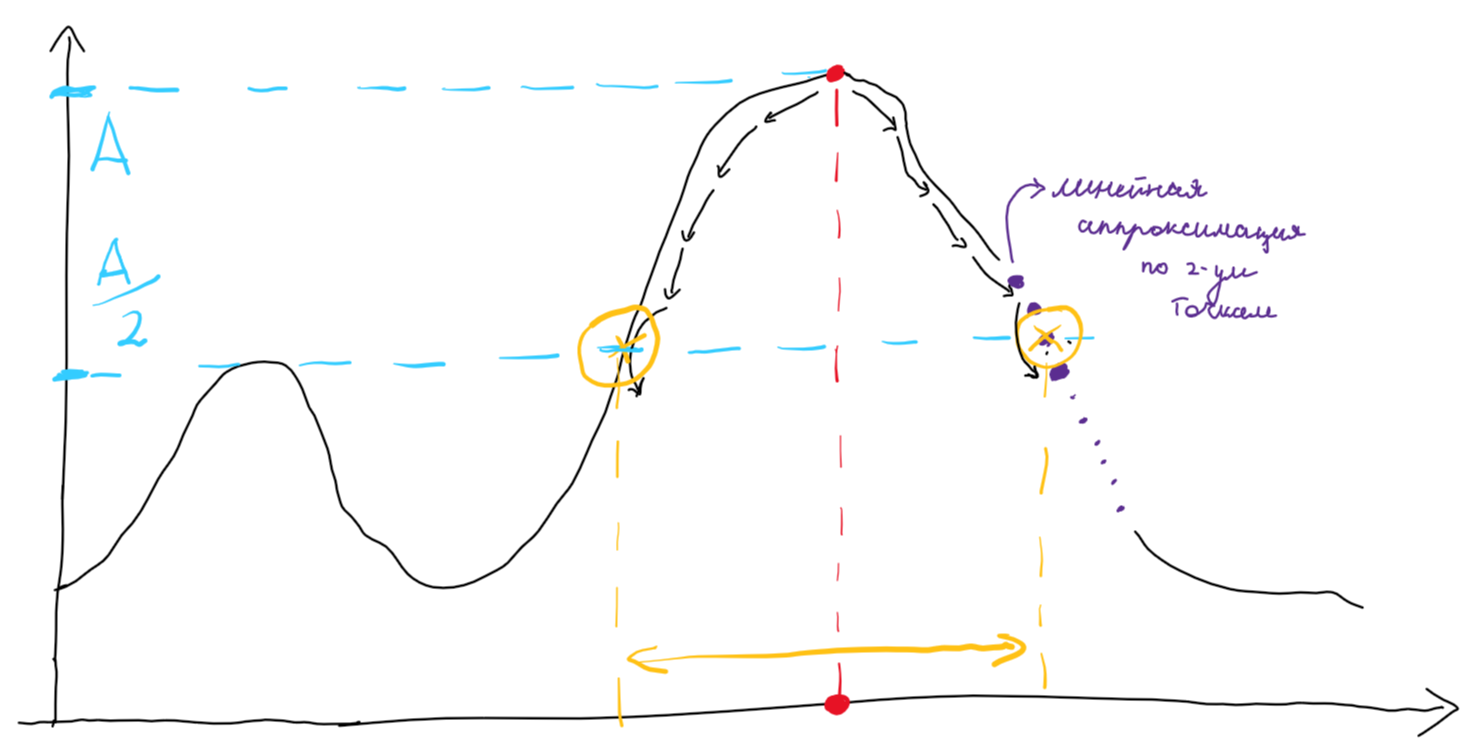

In [21]:
i = 0 # Number of peak
l_width, l_xy_width = maximum_width_est(df, EX_EM_list, coordinates=coordinates)
print(f'l_xy_width: {l_xy_width}')
print(f'l_width: {l_width}')

l_xy_width: [array([[350, 410],
       [350, 484],
       [320, 444],
       [380, 444]])]
l_width: [[410.8582233665921, 483.8258126429265, 320.8676986507974, 376.90848324602166]]


In [22]:
i = 0 # Number of peak
l_I = maximum_integral_est(df, EX_EM_list, coordinates=coordinates, k=0.0)
print(f'l_I: {l_I}')

l_I: [array([28846.338, 41486.105,  5887.098,  5271.384])]


X-dispertion:
[410, 484]


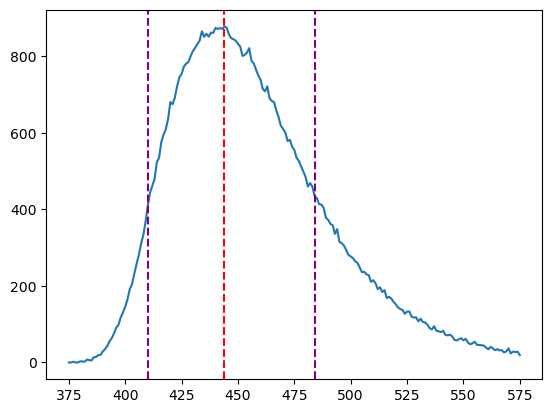

Y-dispertion:
[320, 380]


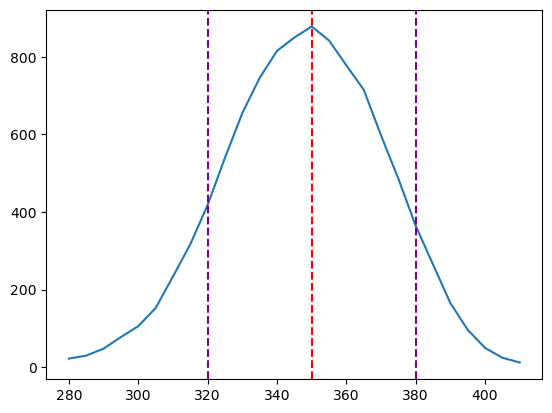

In [23]:
# Plotting results
x_width = [l_xy_width[0][0][1], l_xy_width[0][1][1]]
y_width = [l_xy_width[0][2][0], l_xy_width[0][3][0]]

#x_disp
print(f'X-dispertion:\n{x_width}')
plt.plot(df_filt.columns, df_filt.loc[EX_EM_list[i][0]])
plt.axvline(x=EX_EM_list[i][1], color='r', ls='--')
plt.axvline(x=x_width[0], color='purple', ls='--')
plt.axvline(x=x_width[1], color='purple', ls='--')
plt.show()

#y_disp
print(f'Y-dispertion:\n{y_width}')
plt.plot(df_filt.index, df_filt.loc[:,EX_EM_list[i][1]])
plt.axvline(x=EX_EM_list[i][0], color='r', ls='--')
plt.axvline(x=y_width[0], color='purple', ls='--')
plt.axvline(x=y_width[1], color='purple', ls='--')
plt.show()

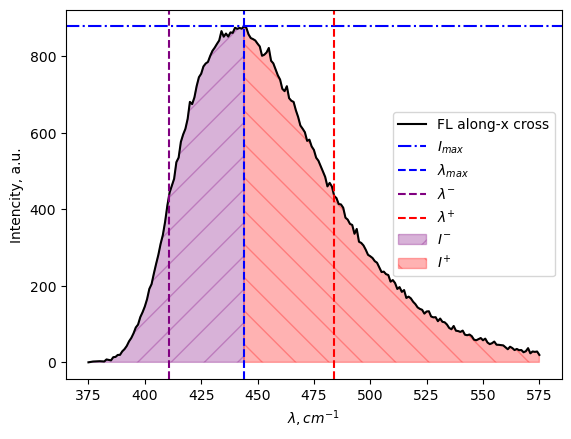

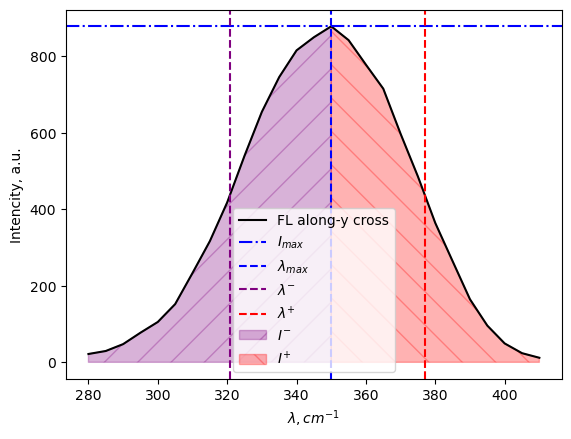

l_I: None


In [24]:
i = 0 # Number of peak
l_I = plot_est(df, EX_EM_list, coordinates=coordinates, k_x=0.5, k_I=0.)
print(f'l_I: {l_I}')

# Обработаем все файлы таким образом

In [96]:
def process_FL(filename, 
               blowouts_ker_size = [3, 5],
               iter_filt_trash_h = -0.5, 
               iter_filt_ker_size = [3, 15],
               smooth_sigma = [0,3],# [0,3]
               num_peaks = 1,
               k_x = 0.5,
               k_I = 0.,
               plot = True
               ):
    '''
    Returns information of FL`s maximas in view:
    [I_1, x_1, y_1, sigma_x_1_low, sigma_x_1_high, sigma_y_1_low, sigma_y_1_high,
     I_2, x_2, y_2, sigma_x_2_low, sigma_x_2_high, sigma_y_2_low, sigma_y_2_high]
     
    filename: name of the file.
    plot: plot FL with detcted maximas and their dispersions.
    '''
    
    '''
    ToDo:
    1. Return sigma, not points
    2. Make a func to eval integrals
    3. implement it here
    '''

    # 1. Importing FL-map
    df = import_df(filename)
    
    # 2. Filtering blowouts
    df_bo = blow_outs_filt(df, ker_size = blowouts_ker_size)
    
    # 3. Iterative filter
    df_filt = iter_filter(df_bo, trash_h = iter_filt_trash_h, ker_size = iter_filt_ker_size, delta = 1/np.prod(df_bo.shape))
    
    # Set None-pixels as 0
    df_filt[df_filt!=df_filt] = 0
    
    # 4. Deleting lines and interpolation
    df_no_lines = lines_deleting(df_filt)
    df_no_lines = (df_no_lines.interpolate(axis=0, limit_direction = 'both') + df_no_lines.interpolate(axis=1, limit_direction = 'both')) / 2
    
    # 5. Evaluating coordinates of 2 maximas
    df_filt_1 = df_no_lines.copy()
    
    # Smooth df for better maximum recognition
    np_df_smoothed = np.array(df_filt_1)
    np_df_smoothed = ndimage.gaussian_filter(np_df_smoothed, sigma = smooth_sigma)
    df_filt_s = pd.DataFrame(np_df_smoothed, index=df.index, columns=df.columns)
    
    coordinates = find_peaks(df_filt_s, num_peaks = num_peaks)
    coordinates = sorted(coordinates, key = lambda x: x[0]) ###
    
    # Getting Wavelength numbers
    EX_EM_list = [[df.index[coordinates[i][0]], df.columns[coordinates[i][1]]] for i in range(len(coordinates))]

    # 6. Evaluating dispertions and integrals around maximas
    l_width, l_xy_width = maximum_width_est(df_filt_s, EX_EM_list, coordinates = coordinates, k = k_x)
    l_I = maximum_integral_est(df_filt_s, EX_EM_list, coordinates = coordinates, k = k_I)
    
    # Plotting 
    if plot:
        #print(f'coordinates')
        p_show_img(df_filt_1, filename, points = coordinates, 
                   l_xy_width=l_xy_width)
        plot_est(df_filt_s, EX_EM_list, coordinates, )
    
    return np.array(
        [[df_filt.loc[*EX_EM_list[i]],  # Intencity I
             *EX_EM_list[i][::-1], # Maximum wavenumbers *[y, x][::-1]
             *l_width[i], # Dispertions *[left_bound, right_bound, down_bound, up_bound]
             *l_I[i]] # Integrals: *[I_x_left, I_x_right, I_y_down, I_y_up]
            for i in range(len(coordinates))])

In [97]:
filename='1.csv'

process_FL(filename, plot=0)

array([[ 1094.013     ,   440.        ,   350.        ,   410.99707837,
          483.9855134 ,   319.83708775,   377.14144383, 32092.94681147,
        55681.42098333,  7526.35487914,  6554.21769972]])

In [98]:
def iter_fl_proc(start = 0, 
                 step = 10,
                 source_path = '..\CD_HM_dataset\\'):
    l_filename = listdir(source_path)

    for local_start in range(start, len(l_filename), step):
        local_end = local_start + step
        
        massive = []
        print(f'local_start: {local_start}')
        print(f'local_end: {local_end}')
        for filename in l_filename[local_start:local_end]: # First *step* FL-images processing
            print(filename)
            massive.append(process_FL(filename).ravel())
            #print(massive[-1])
            
        yield massive 
            
    return 

fl = iter_fl_proc(step=1)

local_start: 0
local_end: 1
1.csv


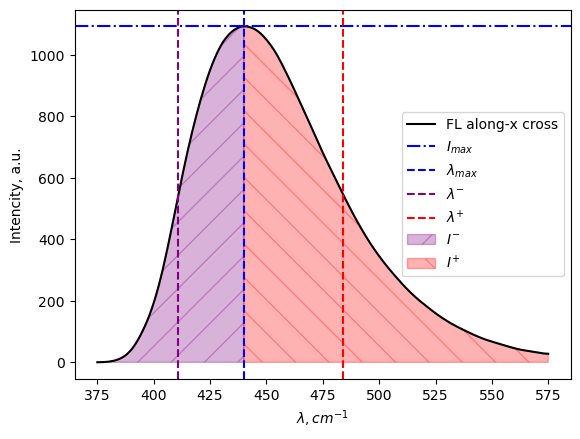

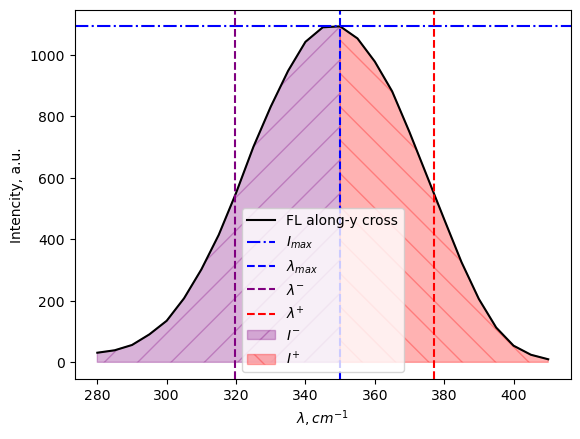

[array([ 1094.013     ,   440.        ,   350.        ,   410.99707837,
          483.9855134 ,   319.83708775,   377.14144383, 32092.94681147,
        55681.42098333,  7526.35487914,  6554.21769972])]

In [99]:
next(fl)

In [400]:
annotations_file = '../CD_HM_dataset/Y_ions.csv'

spec_labels = pd.read_csv(annotations_file, index_col='num')
spec_labels

,Cu,Ni,Pb,Al,Co,Cr,NO3
num,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3.0,9.0
3,0.0,0.0,0.0,0.0,0.0,6.0,18.0
4,0.0,0.0,0.0,0.0,1.5,1.5,7.5
5,0.0,0.0,0.0,0.0,1.5,4.5,16.5
...,...,...,...,...,...,...,...
7809,6.0,6.0,6.0,6.0,4.5,1.5,67.5
7810,6.0,6.0,6.0,6.0,4.5,4.5,76.5
7811,6.0,6.0,6.0,6.0,6.0,0.0,66.0


In [88]:
def iter_fl_proc(start = 0, 
                 step = None,
                 smooth_sigma=0,
                 plot=False,
                 source_path = '..\CD_HM_dataset\\',
                 annotations_file = '..\CD_HM_dataset\Y_ions.csv'
                 ):
    '''
    Iterator for iterative optional batch-augmenting FL maps, visualisation.
    To process all FL maps at once: set {step=None, plot=False}
    '''
    spec_labels = pd.read_csv(annotations_file, index_col='num')
    l_filename = listdir(source_path)
    if step==None: step = len(l_filename)
    
    columns_out_df=['idx', 
            'I',
            'x', 'y', 
            'left_bound', 'right_bound', 'down_bound', 'up_bound',
            'I_x_left', 'I_x_right', 'I_y_down', 'I_y_up'] + \
                                    list(spec_labels.columns)
                                    
    out_df = pd.DataFrame(columns=columns_out_df)

    # Iterating through batch of aggregation FL
    for local_start in range(start, len(l_filename), step):
        local_end = local_start + step
        
        massive = []
        #print(f'local_start: {local_start}')
        #print(f'local_end: {local_end}')
        
        # Process 1 FL
        for filename in tqdm(l_filename[local_start:local_end]): # First *step* FL-images processing
            if filename in ['Y_ions.csv', 'Y_ions.xlsx']: continue
            idx = int(filename.split('.')[0])
            
            augmented_FL = process_FL(filename, 
                                      smooth_sigma=smooth_sigma,
                                      plot=plot).ravel()
            
            #print()
            #print(f'idx: {idx}')
            #print(f'list(augmented_FL): {list(augmented_FL)}')
            #print(f'list(spec_labels.loc[idx]):{list(spec_labels.loc[idx])}')
            
            raw = [idx] + list(augmented_FL) + list(spec_labels.loc[idx])
            massive.append(raw)
            #print(massive[-1])
            
        batch_df = pd.DataFrame(massive, columns=columns_out_df)
        out_df = pd.concat([out_df,batch_df])
        
        yield batch_df 
            
    return out_df


fl_1 = iter_fl_proc(step=10, start=0, plot=True)

In [410]:
df1 = next(fl_1)
df1

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:01,  7.14it/s]

 20%|██        | 2/10 [00:00<00:01,  6.94it/s]

 30%|███       | 3/10 [00:00<00:00,  7.22it/s]

 40%|████      | 4/10 [00:00<00:00,  6.72it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.39it/s]

 60%|██████    | 6/10 [00:00<00:00,  8.05it/s]

 70%|███████   | 7/10 [00:00<00:00,  8.38it/s]

 90%|█████████ | 9/10 [00:01<00:00,  9.93it/s]

100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


,idx,I,x,y,left_bound,right_bound,down_bound,up_bound,I_x_left,I_x_right,I_y_down,I_y_up,Cu,Ni,Pb,Al,Co,Cr,NO3
0,1016,475.796,444.0,350.0,413.424685,489.385960,323.122777,379.929299,14481.674,25069.446,2932.505,3121.183,0.0,4.5,1.5,1.5,1.5,0.0,19.5
1,1017,213.173,450.0,350.0,415.626874,497.286512,323.318887,381.254327,7274.699,11474.313,1294.458,1459.371,0.0,4.5,1.5,1.5,1.5,3.0,28.5
2,1018,147.311,450.0,355.0,419.066674,500.857569,326.259532,381.119558,4406.403,8386.394,935.971,868.107,0.0,4.5,1.5,1.5,1.5,6.0,37.5
3,1019,198.047,450.0,350.0,415.155366,493.732473,323.370226,381.846378,6839.612,9963.847,1175.964,1367.415,0.0,4.5,1.5,1.5,3.0,1.5,27.0
4,102,258.651,455.0,355.0,417.189120,503.852130,326.991913,385.120553,9545.800,14324.998,1672.343,1709.847,0.0,0.0,1.5,4.5,0.0,3.0,25.5
5,1020,146.880,452.0,355.0,417.573590,500.729580,325.412677,382.957096,4979.334,7918.670,957.292,909.104,0.0,4.5,1.5,1.5,3.0,4.5,36.0
6,1021,379.140,448.0,350.0,413.171749,490.187888,323.447552,380.975171,13093.177,18464.694,2300.670,2582.257,0.0,4.5,1.5,1.5,4.5,0.0,25.5
7,1022,161.088,450.0,355.0,415.905523,495.758865,325.407314,382.746427,5363.323,8585.121,1053.004,989.030,0.0,4.5,1.5,1.5,4.5,3.0,34.5
8,1023,103.096,455.0,355.0,419.514099,499.915895,326.836593,384.824020,3604.342,5269.530,653.791,668.132,0.0,4.5,1.5,1.5,4.5,6.0,43.5
9,1024,140.624,450.0,355.0,416.393818,492.571042,325.485852,382.842770,4671.447,6948.691,939.598,862.812,0.0,4.5,1.5,1.5,6.0,1.5,33.0


In [89]:
fl_fin = iter_fl_proc(smooth_sigma=[0,3])

In [90]:
df_fin = next(fl_fin)

100%|██████████| 7815/7815 [06:50<00:00, 19.05it/s]


In [91]:
df_fin

,idx,I,x,y,left_bound,right_bound,down_bound,up_bound,I_x_left,I_x_right,I_y_down,I_y_up,Cu,Ni,Pb,Al,Co,Cr,NO3
0,1,1094.013,440.0,350.0,410.997078,483.985513,319.837088,377.141444,32092.946811,55681.420983,7526.354879,6554.217700,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,202.294,450.0,350.0,414.577059,498.744699,323.395276,380.964878,6988.960165,10871.964268,1184.090837,1342.087958,0.0,0.0,0.0,0.0,4.5,4.5,22.5
2,100,177.025,454.0,355.0,417.197886,502.827048,327.105424,383.454723,6662.354552,9932.300708,1123.217310,1146.207041,0.0,0.0,1.5,3.0,6.0,4.5,37.5
3,1000,191.846,455.0,355.0,418.799921,504.925887,327.328667,383.479384,6944.652646,10680.836195,1170.757224,1225.503524,0.0,4.5,0.0,6.0,6.0,4.5,52.5
4,1001,631.573,441.0,350.0,411.644120,485.927998,321.419781,377.998183,18644.724966,32540.515302,4147.462148,3894.747976,0.0,4.5,1.5,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7808,995,246.346,456.0,355.0,418.914238,505.600813,327.041189,383.432359,9085.038092,13701.728784,1521.052042,1555.695514,0.0,4.5,0.0,6.0,3.0,4.5,46.5
7809,996,399.123,456.0,360.0,422.002086,505.372822,328.436916,390.751460,13991.087131,22430.024973,2782.018995,2715.377589,0.0,4.5,0.0,6.0,4.5,0.0,36.0
7810,997,256.685,454.0,355.0,417.657632,504.495323,326.466136,383.546410,9514.945313,14770.350457,1663.446831,1668.043184,0.0,4.5,0.0,6.0,4.5,3.0,45.0
7811,998,198.192,458.0,355.0,419.720741,506.971984,327.135124,383.507781,7526.795281,10797.663587,1207.006519,1253.372564,0.0,4.5,0.0,6.0,4.5,6.0,54.0


In [92]:
df_fin.loc[:,['I', 'x', 'y']]

,I,x,y
0,1094.013,440.0,350.0
1,202.294,450.0,350.0
2,177.025,454.0,355.0
3,191.846,455.0,355.0
4,631.573,441.0,350.0
...,...,...,...
7808,246.346,456.0,355.0
7809,399.123,456.0,360.0
7810,256.685,454.0,355.0
7811,198.192,458.0,355.0


### Данные в таблицу оформляются следующим образом:
1. Каждая строчка - одна обработанная карта FL.
2. Индекс - номер файла, число перед '.csv' в названии карты FL.
3. Столбцы расположены в следующем порядке:

* I	- Интенсивность пика в FL карте (отн. ед.).
* x	- Длина волны испускания в максимуме интенсивности ($см^{-1}$).
* y	- Длина волны возбуждения в максимуме интенсивности ($см^{-1}$).
* left_bound - Левая граница длины волны испускания на полувысоте интенсивности ($см^{-1}$).
* right_bound - Правая граница длины волны испускания на полувысоте интенсивности ($см^{-1}$).
* down_bound - Нижняя граница длины волны поглощения на полувысоте интенсивности ($см^{-1}$).
* up_bound - Верхняя граница длины волны поглощения на полувысоте интенсивности ($см^{-1}$).
* I_x_left - Интеграл левого крыла вдоль длины волны испускания на полувысоте интенсивности ($см^{-1}$).
* I_x_right - Интеграл правого крыла вдоль длины волны испускания на полувысоте интенсивности ($см^{-1}$).
* I_y_down - Интеграл нижнего крыла вдоль длины волны возбуждения на полувысоте интенсивности ($см^{-1}$).
* I_y_up - Интеграл верхнего крыла вдоль длины волны возбуждения на полувысоте интенсивности ($см^{-1}$).
* Cu, Ni, Pb, Al, Co, Cr, NO3 - Концентрации соответствующих ионов (мМ)

In [93]:
df_fin.to_excel("FL_augm_inter_w_smooth.xlsx")
df_fin.to_csv("FL_augm_inter_w_smooth.csv")